In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import shutil
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load CSV file containing image IDs and labels
csv_file_id = "1NH-jvwPFytwAJSL_uhlMDLwBI5PHRvJW"
csv_file = drive.CreateFile({'id': csv_file_id})
csv_file.GetContentFile("ISIC-2017_Training_Part3_GroundTruth.csv")

# Load ZIP file containing images
zip_file_id = "1pWLAcNGTcJf8rLp2RIs5BSBvLZovFiCd"
zip_file = drive.CreateFile({'id': zip_file_id})
zip_file.GetContentFile("ISIC-2017_Training_Data.zip")

# Unzip the image data
with zipfile.ZipFile("ISIC-2017_Training_Data.zip", 'r') as zip_ref:
    zip_ref.extractall("extracted_images")

# Preprocess images and create dataset
image_dir = "extracted_images/ISIC-2017_Training_Data"  # Adjusted directory path

# Load CSV file containing image IDs and labels
df = pd.read_csv("ISIC-2017_Training_Part3_GroundTruth.csv")

# Create new directories for melanoma and non-melanoma images
melanoma_dir = "melanoma_images"
non_melanoma_dir = "non_melanoma_images"

os.makedirs(melanoma_dir, exist_ok=True)
os.makedirs(non_melanoma_dir, exist_ok=True)

# Segregate images based on melanoma label
for index, row in df.iterrows():
    img_id = row['image_id']
    img_path = os.path.join(image_dir, img_id + ".jpg")

    # Check if the image file exists
    if not os.path.exists(img_path):
        print("Image file not found:", img_path)
        continue

    # Determine the directory based on the 'melanoma' column
    if row['melanoma'] == 1:
        destination_dir = melanoma_dir
    else:
        destination_dir = non_melanoma_dir

    # Move the image file to the corresponding directory
    shutil.copy(img_path, destination_dir)

print("Images preprocessed successfully.")




Images preprocessed successfully.


In [2]:
import os
import numpy as np
import cv2
import albumentations as A


# Count the number of images in each directory
num_melanoma_images = len(os.listdir(melanoma_dir))
num_non_melanoma_images = len(os.listdir(non_melanoma_dir))

# Define augmentations
transform = A.Compose([
    A.Rotate(limit=20, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2)
])

# Determine which class has fewer images
if num_non_melanoma_images < num_melanoma_images:
    class_to_augment = non_melanoma_dir
    augmentation_factor = num_melanoma_images // num_non_melanoma_images
else:
    class_to_augment = melanoma_dir
    augmentation_factor = num_non_melanoma_images // num_melanoma_images

# Perform augmentation for the class with fewer images
class_images = os.listdir(class_to_augment)
for img_file in class_images:
    img_path = os.path.join(class_to_augment, img_file)
    image = cv2.imread(img_path)

    # Apply augmentations
    for i in range(augmentation_factor):
        augmented = transform(image=image)
        img_aug = augmented['image']

        # Save augmented image
        save_path = os.path.join(class_to_augment, f"aug_{i}_{img_file}")
        cv2.imwrite(save_path, img_aug)

print("Images augmented successfully.")









Images augmented successfully.


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use GPU with ID 0

In [5]:
# List images in melanoma_images directory
print("Images in melanoma_images directory:")
melanoma_images = os.listdir(melanoma_dir)
print(melanoma_images)

# List images in non_melanoma_images directory
print("\nImages in non_melanoma_images directory:")
non_melanoma_images = os.listdir(non_melanoma_dir)
print(non_melanoma_images)

Images in melanoma_images directory:
['aug_3_ISIC_0000298.jpg', 'ISIC_0013831.jpg', 'aug_3_ISIC_0014347.jpg', 'aug_0_ISIC_0010372.jpg', 'aug_0_ISIC_0013845.jpg', 'aug_2_ISIC_0013674.jpg', 'ISIC_0010011.jpg', 'aug_3_ISIC_0000022.jpg', 'aug_0_ISIC_0015189.jpg', 'aug_1_ISIC_0012382.jpg', 'aug_3_ISIC_0000030.jpg', 'aug_0_ISIC_0014987.jpg', 'aug_0_ISIC_0013184.jpg', 'aug_2_ISIC_0014157.jpg', 'aug_3_ISIC_0014337.jpg', 'aug_1_ISIC_0000299.jpg', 'ISIC_0012298.jpg', 'aug_2_ISIC_0000547.jpg', 'aug_2_ISIC_0014975.jpg', 'ISIC_0013594.jpg', 'aug_2_ISIC_0013775.jpg', 'aug_1_ISIC_0014013.jpg', 'ISIC_0013674.jpg', 'aug_0_ISIC_0001103.jpg', 'aug_2_ISIC_0000164.jpg', 'aug_0_ISIC_0014422.jpg', 'aug_2_ISIC_0000002.jpg', 'aug_1_ISIC_0001128.jpg', 'aug_1_ISIC_0000174.jpg', 'aug_0_ISIC_0014507.jpg', 'aug_3_ISIC_0013618.jpg', 'aug_1_ISIC_0014327.jpg', 'aug_1_ISIC_0012715.jpg', 'ISIC_0000410.jpg', 'aug_0_ISIC_0000166.jpg', 'aug_2_ISIC_0014076.jpg', 'aug_0_ISIC_0011140.jpg', 'aug_2_ISIC_0000292.jpg', 'aug_2_ISI

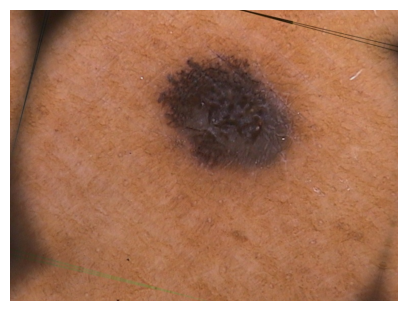

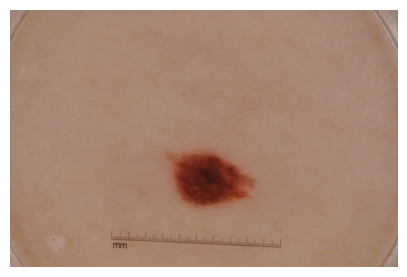

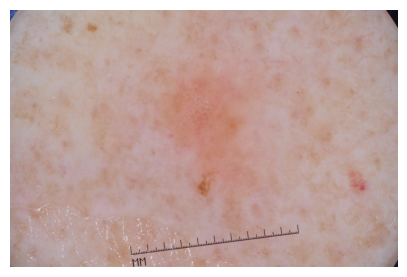

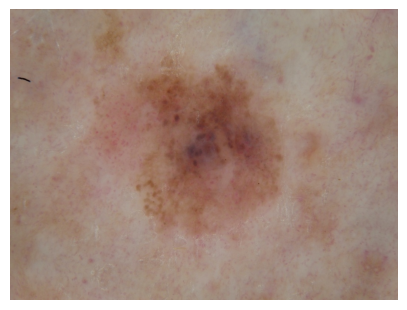

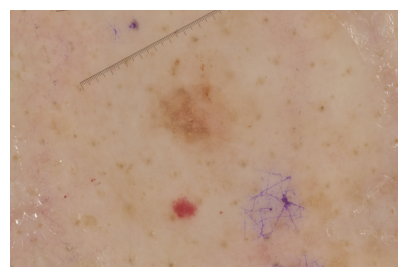

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Path to the directory containing melanoma images
melanoma_dir = "melanoma_images"

# Get list of image files in the directory
image_files = os.listdir(melanoma_dir)

# Display the first 5 images
num_images_to_display = 5
for i in range(num_images_to_display):
    img_path = os.path.join(melanoma_dir, image_files[i])
    img = mpimg.imread(img_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [7]:
import os
import shutil
import random

# Define source directories
source_melanoma = 'melanoma_images'
source_non_melanoma = 'non_melanoma_images'

# Define target directories
train_melanoma_dir = 'train_melanoma'
validation_melanoma_dir = 'validation_melanoma'
test_melanoma_dir = 'test_melanoma'

train_non_melanoma_dir = 'train_non_melanoma'
validation_non_melanoma_dir = 'validation_non_melanoma'
test_non_melanoma_dir = 'test_non_melanoma'

# Create target directories
os.makedirs(train_melanoma_dir, exist_ok=True)
os.makedirs(validation_melanoma_dir, exist_ok=True)
os.makedirs(test_melanoma_dir, exist_ok=True)

os.makedirs(train_non_melanoma_dir, exist_ok=True)
os.makedirs(validation_non_melanoma_dir, exist_ok=True)
os.makedirs(test_non_melanoma_dir, exist_ok=True)

# Function to split images
def split_data(source, train, validation, test, split_ratio=(0.6, 0.2, 0.2)):
    files = os.listdir(source)
    random.shuffle(files)
    total_files = len(files)
    train_split = int(total_files * split_ratio[0])
    validation_split = int(total_files * (split_ratio[0] + split_ratio[1]))

    train_files = files[:train_split]
    validation_files = files[train_split:validation_split]
    test_files = files[validation_split:]

    for file in train_files:
        shutil.copy(os.path.join(source, file), os.path.join(train, file))

    for file in validation_files:
        shutil.copy(os.path.join(source, file), os.path.join(validation, file))

    for file in test_files:
        shutil.copy(os.path.join(source, file), os.path.join(test, file))

# Split melanoma images
split_data(source_melanoma, train_melanoma_dir, validation_melanoma_dir, test_melanoma_dir)

# Split non-melanoma images
split_data(source_non_melanoma, train_non_melanoma_dir, validation_non_melanoma_dir, test_non_melanoma_dir)

print("Data split successfully.")

Data split successfully.


In [8]:
import os
import shutil

# Define the mother directory name
mother_directory = 'train_data'


# Create the mother directory if it doesn't exist
if not os.path.exists(mother_directory):
    os.makedirs(mother_directory)

# Move train_melanoma directory into the mother directory
shutil.move('train_melanoma', os.path.join(mother_directory, 'train_melanoma'))

# Move train_non_melanoma directory into the mother directory
shutil.move('train_non_melanoma', os.path.join(mother_directory, 'train_non_melanoma'))

print("Directories moved successfully.")

Directories moved successfully.


In [9]:
import os
import shutil

# Define the mother directory names
mother_validation_directory = 'validation_data'
mother_test_directory = 'test_data'

# Create the mother directories if they don't exist
if not os.path.exists(mother_validation_directory):
    os.makedirs(mother_validation_directory)
if not os.path.exists(mother_test_directory):
    os.makedirs(mother_test_directory)

# Move validation_melanoma directory into the mother validation directory
shutil.move('validation_melanoma', os.path.join(mother_validation_directory, 'validation_melanoma'))

# Move validation_non_melanoma directory into the mother validation directory
shutil.move('validation_non_melanoma', os.path.join(mother_validation_directory, 'validation_non_melanoma'))

# Move test_melanoma directory into the mother test directory
shutil.move('test_melanoma', os.path.join(mother_test_directory, 'test_melanoma'))

# Move test_non_melanoma directory into the mother test directory
shutil.move('test_non_melanoma', os.path.join(mother_test_directory, 'test_non_melanoma'))

print("Directories moved successfully.")

Directories moved successfully.


MODEL 1: INCEPTION V3

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 299, 299  # InceptionV3 input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load InceptionV3 base model
base_model = InceptionV3(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")

# Define the mother directory names
mother_validation_directory = 'validation_data'
mother_test_directory = 'test_data'

# Create the mother directories if they don't exist
if not os.path.exists(mother_validation_directory):
    os.makedirs(mother_validation_directory)
if not os.path.exists(mother_test_directory):
    os.makedirs(mother_test_directory)

# Move validation_melanoma directory into the mother validation directory
shutil.move('validation_melanoma', os.path.join(mother_validation_directory, 'validation_melanoma'))

# Move validation_non_melanoma directory into the mother validation directory
shutil.move('validation_non_melanoma', os.path.join(mother_validation_directory, 'validation_non_melanoma'))

# Move test_melanoma directory into the mother test directory
shutil.move('test_melanoma', os.path.join(mother_test_directory, 'test_melanoma'))

# Move test_non_melanoma directory into the mother test directory
shutil.move('test_non_melanoma', os.path.join(mother_test_directory, 'test_non_melanoma'))

print("Directories moved successfully.")







Found 2097 images belonging to 2 classes.
Found 699 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/50
66/66 [==============================] - 217s 3s/step - loss: 0.6606 - accuracy: 0.6242 - val_loss: 0.5807 - val_accuracy: 0.6881
Epoch 2/50
66/66 [==============================] - 201s 3s/step - loss: 0.5938 - accuracy: 0.6781 - val_loss: 0.5585 - val_accuracy: 0.7225
Epoch 3/50
66/66 [==============================] - 208s 3s/step - loss: 0.5516 - accuracy: 0.7082 - val_loss: 0.5415 - val_accuracy: 0.7196
Epoch 4/50
66/66 [==============================] - 203s 3s/step - loss: 0.5468 - accuracy: 0.7191 - val_loss: 0.5724 - val_accuracy: 0.6867
Epoch 5/50
66/66 [==============================] - 202s 3s/step - loss: 0.5250 - accuracy: 0.7229 - val_loss: 0.5252 - val_accuracy: 0.7139
Epoch 6/50
66/66 [==============================] - 206s 3s/step - loss: 0.5171 - accuracy: 0.7310 - val_l

FileNotFoundError: [Errno 2] No such file or directory: 'validation_melanoma'

Confusion Matrix:
[[321  53]
 [ 58 268]]


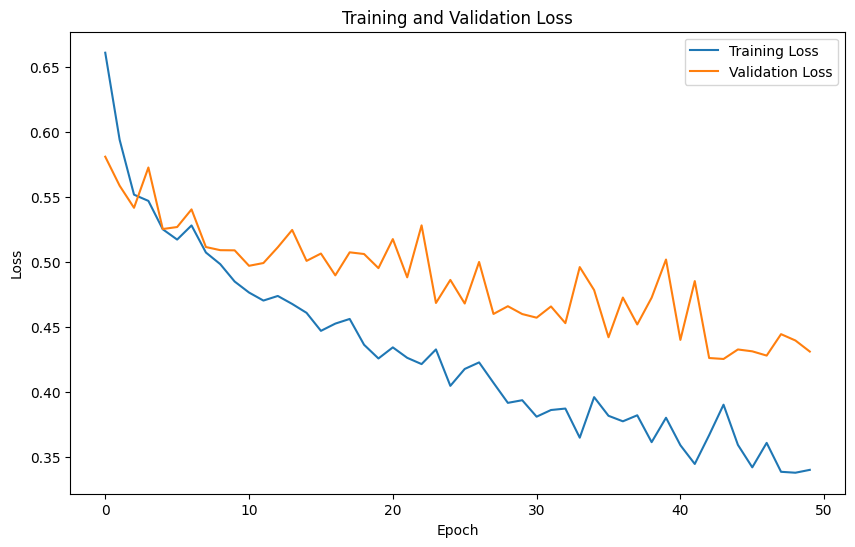

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

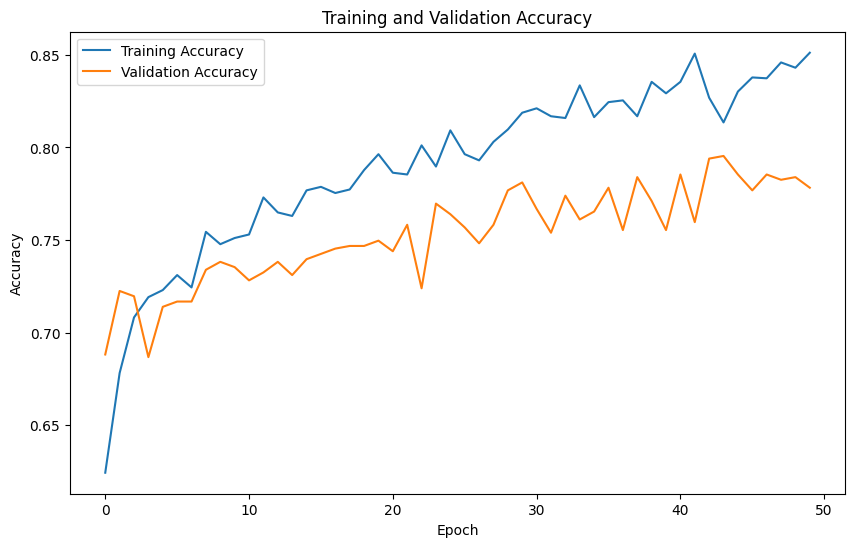

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

MOBILENET : MODEL 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 224, 224  # MobileNet input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load MobileNet base model
base_model = MobileNet(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")

# Define the mother directory names
mother_validation_directory = 'validation_data'
mother_test_directory = 'test_data'

# Create the mother directories if they don't exist
if not os.path.exists(mother_validation_directory):
    os.makedirs(mother_validation_directory)
if not os.path.exists(mother_test_directory):
    os.makedirs(mother_test_directory)

# Move validation_melanoma directory into the mother validation directory
shutil.move('validation_melanoma', os.path.join(mother_validation_directory, 'validation_melanoma'))

# Move validation_non_melanoma directory into the mother validation directory
shutil.move('validation_non_melanoma', os.path.join(mother_validation_directory, 'validation_non_melanoma'))

# Move test_melanoma directory into the mother test directory
shutil.move('test_melanoma', os.path.join(mother_test_directory, 'test_melanoma'))

# Move test_non_melanoma directory into the mother test directory
shutil.move('test_non_melanoma', os.path.join(mother_test_directory, 'test_non_melanoma'))

print("Directories moved successfully.")



Found 2097 images belonging to 2 classes.
Found 699 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
17225924/17225924 [==============================] - 2s 0us/step
Epoch 1/50
66/66 [==============================] - 193s 3s/step - loss: 0.6462 - accuracy: 0.6633 - val_loss: 0.5456 - val_accuracy: 0.7167
Epoch 2/50
66/66 [==============================] - 187s 3s/step - loss: 0.5427 - accuracy: 0.7253 - val_loss: 0.5607 - val_accuracy: 0.6938
Epoch 3/50
66/66 [==============================] - 190s 3s/step - loss: 0.5131 - accuracy: 0.7430 - val_loss: 0.5546 - val_accuracy: 0.6924
Epoch 4/50
66/66 [==============================] - 185s 3s/step - loss: 0.4791 - accuracy: 0.7558 - val_loss: 0.4919 - val_accuracy: 0.7597
Epoch 5/50
66/66 [==============================] - 185s 3s/step - loss: 0.4611 - accuracy: 0.7725 - val_loss: 0.5212 - val_accuracy: 0.7225
Epoch 6/50
66/66 [==============================] - 187s 3s/step - loss: 0.4525 - accuracy: 0.7816 - val_l

FileNotFoundError: [Errno 2] No such file or directory: 'validation_melanoma'

Confusion Matrix:
[[299  75]
 [ 42 284]]


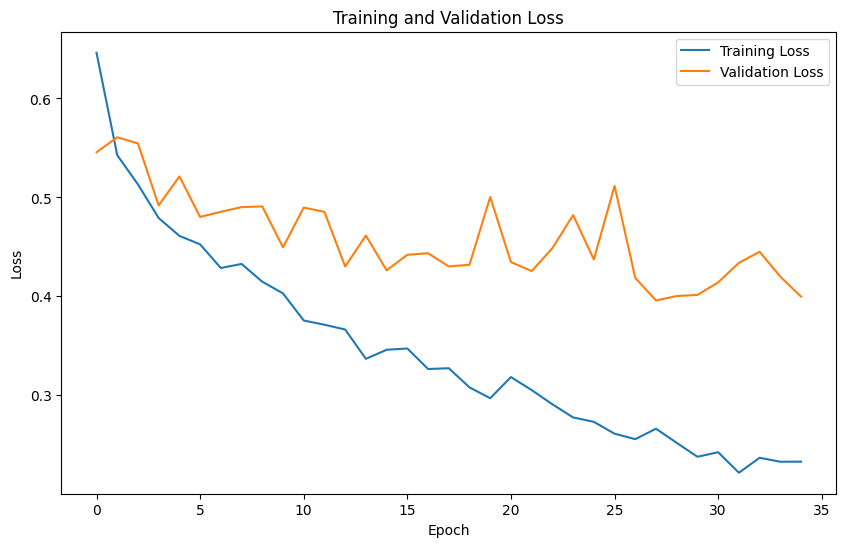

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

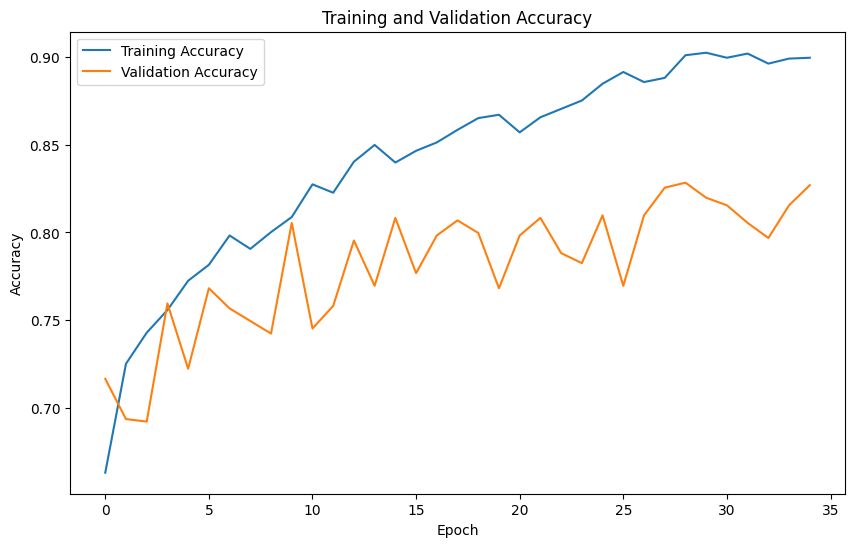

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

MODEL 3: EFFICIENT NET B0

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 224, 224  # EfficientNetB0 input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load EfficientNetB0 base model
base_model = EfficientNetB0(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")

# Define the mother directory names
mother_validation_directory = 'validation_data'
mother_test_directory = 'test_data'

# Create the mother directories if they don't exist
if not os.path.exists(mother_validation_directory):
    os.makedirs(mother_validation_directory)
if not os.path.exists(mother_test_directory):
    os.makedirs(mother_test_directory)

# Move validation_melanoma directory into the mother validation directory
shutil.move('validation_melanoma', os.path.join(mother_validation_directory, 'validation_melanoma'))

# Move validation_non_melanoma directory into the mother validation directory
shutil.move('validation_non_melanoma', os.path.join(mother_validation_directory, 'validation_non_melanoma'))

# Move test_melanoma directory into the mother test directory
shutil.move('test_melanoma', os.path.join(mother_test_directory, 'test_melanoma'))

# Move test_non_melanoma directory into the mother test directory
shutil.move('test_non_melanoma', os.path.join(mother_test_directory, 'test_non_melanoma'))

print("Directories moved successfully.")



Found 2097 images belonging to 2 classes.
Found 699 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/50
66/66 [==============================] - 194s 3s/step - loss: 0.7183 - accuracy: 0.5055 - val_loss: 0.6959 - val_accuracy: 0.5351
Epoch 2/50
66/66 [==============================] - 187s 3s/step - loss: 0.6927 - accuracy: 0.5308 - val_loss: 0.6907 - val_accuracy: 0.5351
Epoch 3/50
66/66 [==============================] - 187s 3s/step - loss: 0.6913 - accuracy: 0.5336 - val_loss: 0.6907 - val_accuracy: 0.5351
Epoch 4/50
66/66 [==============================] - 191s 3s/step - loss: 0.6930 - accuracy: 0.5351 - val_loss: 0.6928 - val_accuracy: 0.5351
Epoch 5/50
66/66 [==============================] - 188s 3s/step - loss: 0.6926 - accuracy: 0.5351 - val_loss: 0.6915 - val_accuracy: 0.5351
Epoch 6/50
66/66 [==============================] - 191s 3s/step - loss: 0.6922 - accuracy: 0.5351 - val_l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

FileNotFoundError: [Errno 2] No such file or directory: 'validation_melanoma'

Confusion Matrix:
[[374   0]
 [326   0]]


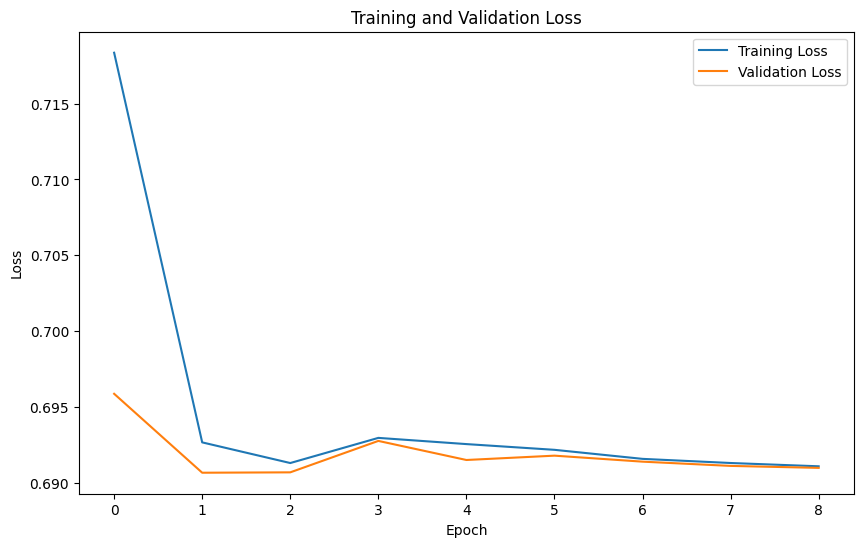

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

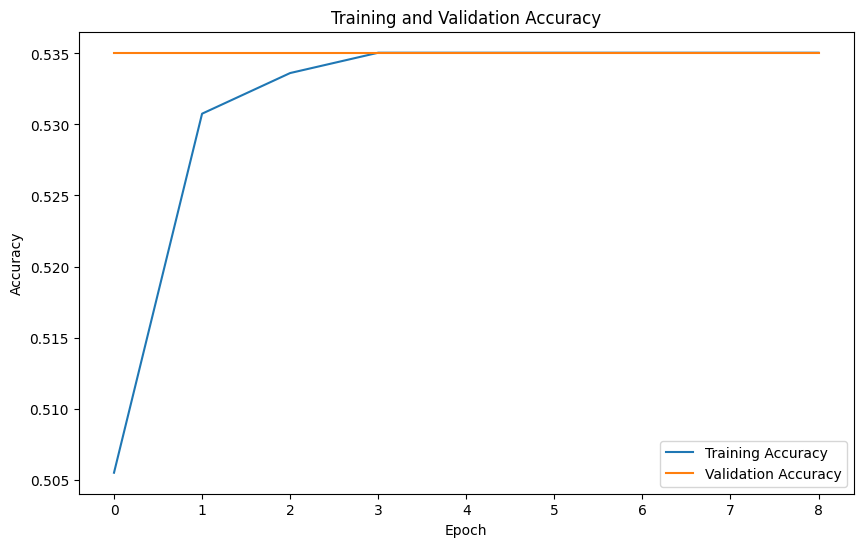

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

MODEL 4: XCEPTION

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 71, 71  # Xception input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load Xception base model
base_model = Xception(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")

# Define the mother directory names
mother_validation_directory = 'validation_data'
mother_test_directory = 'test_data'

# Create the mother directories if they don't exist
if not os.path.exists(mother_validation_directory):
    os.makedirs(mother_validation_directory)
if not os.path.exists(mother_test_directory):
    os.makedirs(mother_test_directory)

# Move validation_melanoma directory into the mother validation directory
shutil.move('validation_melanoma', os.path.join(mother_validation_directory, 'validation_melanoma'))

# Move validation_non_melanoma directory into the mother validation directory
shutil.move('validation_non_melanoma', os.path.join(mother_validation_directory, 'validation_non_melanoma'))

# Move test_melanoma directory into the mother test directory
shutil.move('test_melanoma', os.path.join(mother_test_directory, 'test_melanoma'))

# Move test_non_melanoma directory into the mother test directory
shutil.move('test_non_melanoma', os.path.join(mother_test_directory, 'test_non_melanoma'))

print("Directories moved successfully.")



Found 2097 images belonging to 2 classes.
Found 699 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
83683744/83683744 [==============================] - 5s 0us/step
Epoch 1/50
66/66 [==============================] - 179s 3s/step - loss: 0.7238 - accuracy: 0.6013 - val_loss: 0.6222 - val_accuracy: 0.6710
Epoch 2/50
66/66 [==============================] - 170s 3s/step - loss: 0.6198 - accuracy: 0.6710 - val_loss: 0.6098 - val_accuracy: 0.6681
Epoch 3/50
66/66 [==============================] - 169s 3s/step - loss: 0.5940 - accuracy: 0.6848 - val_loss: 0.6549 - val_accuracy: 0.6581
Epoch 4/50
66/66 [==============================] - 170s 3s/step - loss: 0.5897 - accuracy: 0.6876 - val_loss: 0.5942 - val_accuracy: 0.6738
Epoch 5/50
66/66 [==============================] - 175s 3s/step - loss: 0.5740 - accuracy: 0.7082 - val_loss: 0.5744 - val_accuracy: 0.6981
Epoch 6/50
66/66 [==============================] - 174s 3s/step - loss: 0.5706 - accuracy: 0.7048 - val_l

FileNotFoundError: [Errno 2] No such file or directory: 'validation_melanoma'

Confusion Matrix:
[[279  95]
 [ 82 244]]


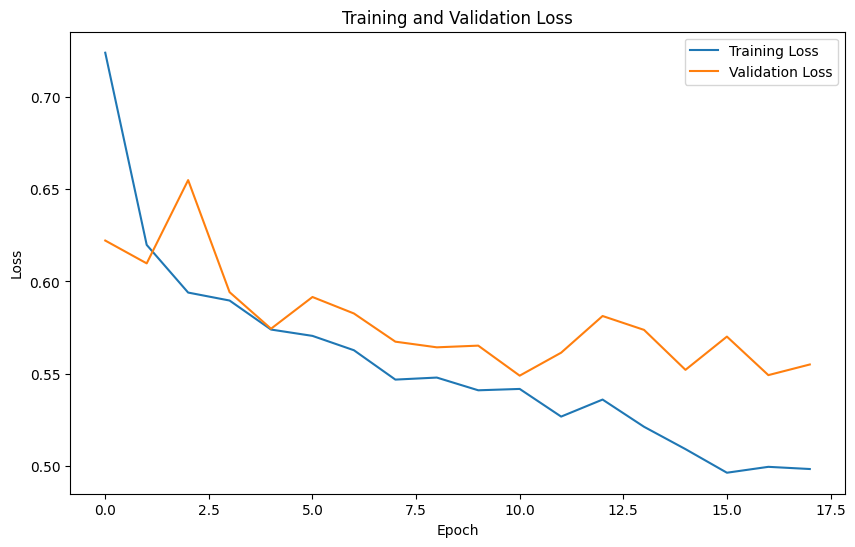

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

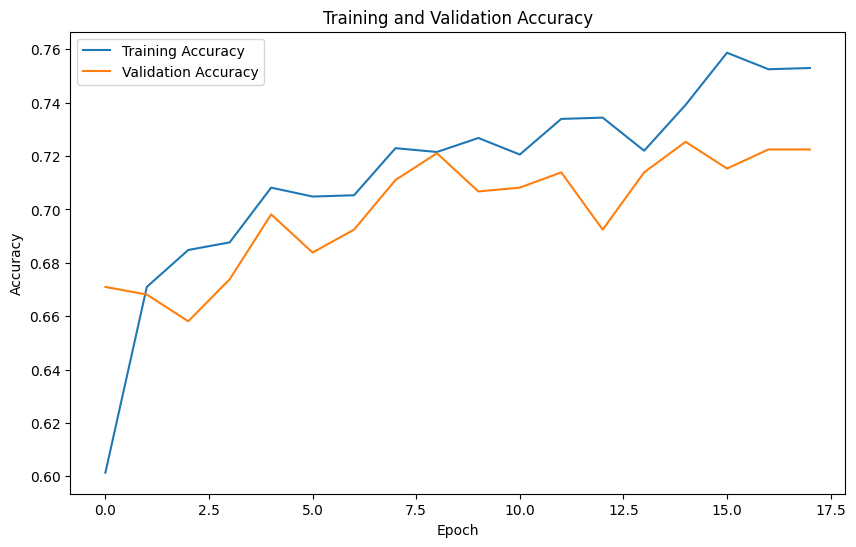

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

MODEL 5: DENSENET 121

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 224, 224  # DenseNet121 input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load DenseNet121 base model
base_model = DenseNet121(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")

# Define the mother directory names
mother_validation_directory = 'validation_data'
mother_test_directory = 'test_data'

# Create the mother directories if they don't exist
if not os.path.exists(mother_validation_directory):
    os.makedirs(mother_validation_directory)
if not os.path.exists(mother_test_directory):
    os.makedirs(mother_test_directory)

# Move validation_melanoma directory into the mother validation directory
shutil.move('validation_melanoma', os.path.join(mother_validation_directory, 'validation_melanoma'))

# Move validation_non_melanoma directory into the mother validation directory
shutil.move('validation_non_melanoma', os.path.join(mother_validation_directory, 'validation_non_melanoma'))

# Move test_melanoma directory into the mother test directory
shutil.move('test_melanoma', os.path.join(mother_test_directory, 'test_melanoma'))

# Move test_non_melanoma directory into the mother test directory
shutil.move('test_non_melanoma', os.path.join(mother_test_directory, 'test_non_melanoma'))

print("Directories moved successfully.")



Found 2097 images belonging to 2 classes.
Found 699 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/50
66/66 [==============================] - 198s 3s/step - loss: 0.6898 - accuracy: 0.6094 - val_loss: 0.5713 - val_accuracy: 0.6981
Epoch 2/50
66/66 [==============================] - 183s 3s/step - loss: 0.5874 - accuracy: 0.6867 - val_loss: 0.5233 - val_accuracy: 0.7268
Epoch 3/50
66/66 [==============================] - 181s 3s/step - loss: 0.5690 - accuracy: 0.6991 - val_loss: 0.4966 - val_accuracy: 0.7654
Epoch 4/50
66/66 [==============================] - 179s 3s/step - loss: 0.5446 - accuracy: 0.7177 - val_loss: 0.5985 - val_accuracy: 0.6652
Epoch 5/50
66/66 [==============================] - 182s 3s/step - loss: 0.5282 - accuracy: 0.7291 - val_loss: 0.4916 - val_accuracy: 0.7597
Epoch 6/50
66/66 [==============================] - 184s 3s/step - loss: 0.5117 - accuracy: 0.7349 - val_l

FileNotFoundError: [Errno 2] No such file or directory: 'validation_melanoma'

Confusion Matrix:
[[280  94]
 [ 44 282]]


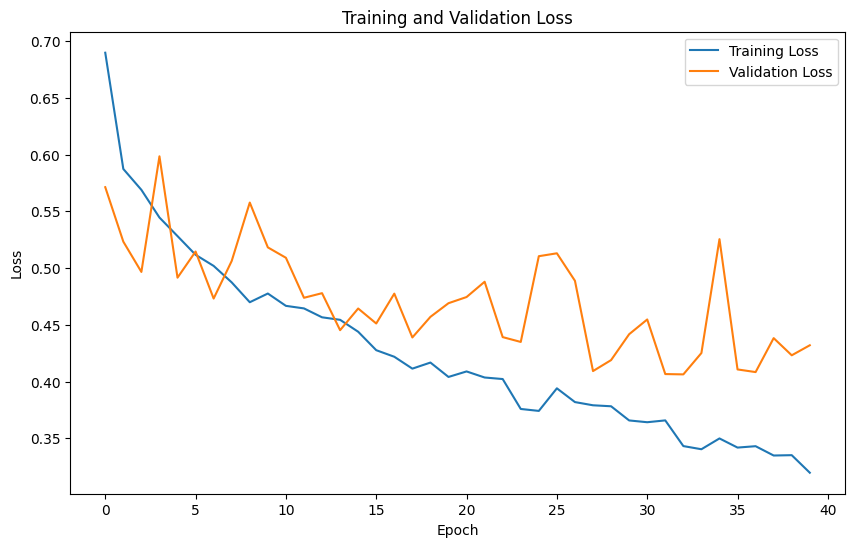

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

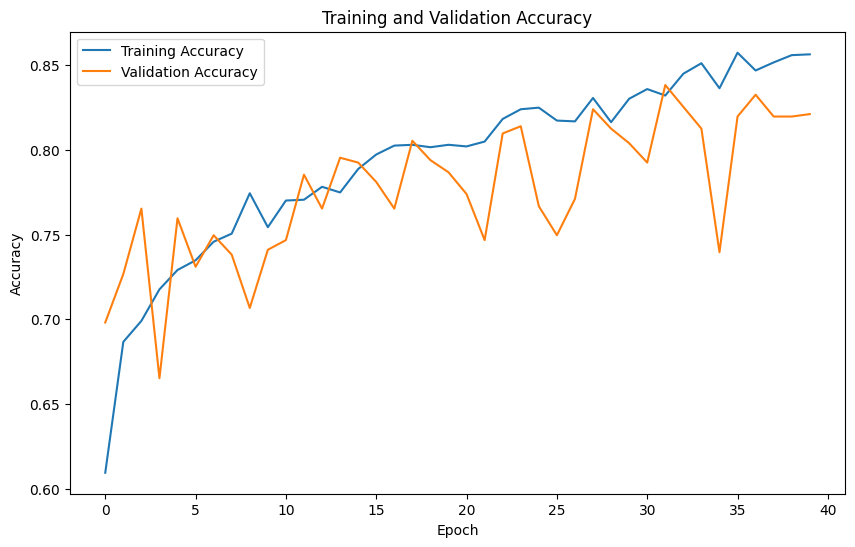

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

MODEL 6: NASNETLARGE

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 331, 331  # NASNetLarge input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load NASNetLarge base model
base_model = NASNetLarge(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")

# Define the mother directory names
mother_validation_directory = 'validation_data'
mother_test_directory = 'test_data'

# Create the mother directories if they don't exist
if not os.path.exists(mother_validation_directory):
    os.makedirs(mother_validation_directory)
if not os.path.exists(mother_test_directory):
    os.makedirs(mother_test_directory)

# Move validation_melanoma directory into the mother validation directory
shutil.move('validation_melanoma', os.path.join(mother_validation_directory, 'validation_melanoma'))

# Move validation_non_melanoma directory into the mother validation directory
shutil.move('validation_non_melanoma', os.path.join(mother_validation_directory, 'validation_non_melanoma'))

# Move test_melanoma directory into the mother test directory
shutil.move('test_melanoma', os.path.join(mother_test_directory, 'test_melanoma'))

# Move test_non_melanoma directory into the mother test directory
shutil.move('test_non_melanoma', os.path.join(mother_test_directory, 'test_non_melanoma'))

print("Directories moved successfully.")


Found 2097 images belonging to 2 classes.
Found 699 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
343610240/343610240 [==============================] - 16s 0us/step
Epoch 1/50
66/66 [==============================] - 244s 3s/step - loss: 0.6221 - accuracy: 0.6595 - val_loss: 0.5567 - val_accuracy: 0.6881
Epoch 2/50
66/66 [==============================] - 204s 3s/step - loss: 0.5467 - accuracy: 0.7144 - val_loss: 0.5474 - val_accuracy: 0.6853
Epoch 3/50
66/66 [==============================] - 204s 3s/step - loss: 0.5344 - accuracy: 0.7210 - val_loss: 0.5284 - val_accuracy: 0.7010
Epoch 4/50
66/66 [==============================] - 203s 3s/step - loss: 0.5098 - accuracy: 0.7330 - val_loss: 0.4913 - val_accuracy: 0.7368
Epoch 5/50
66/66 [==============================] - 203s 3s/step - loss: 0.4756 - accuracy: 0.7630 - val_loss: 0.5189 - val_accuracy: 0.7124
Epoch 6/50
66/66 [==============================] - 203s 3s/step - loss: 0.4741 - accuracy: 0.7597 - va

FileNotFoundError: [Errno 2] No such file or directory: 'validation_melanoma'

Confusion Matrix:
[[311  63]
 [ 63 263]]


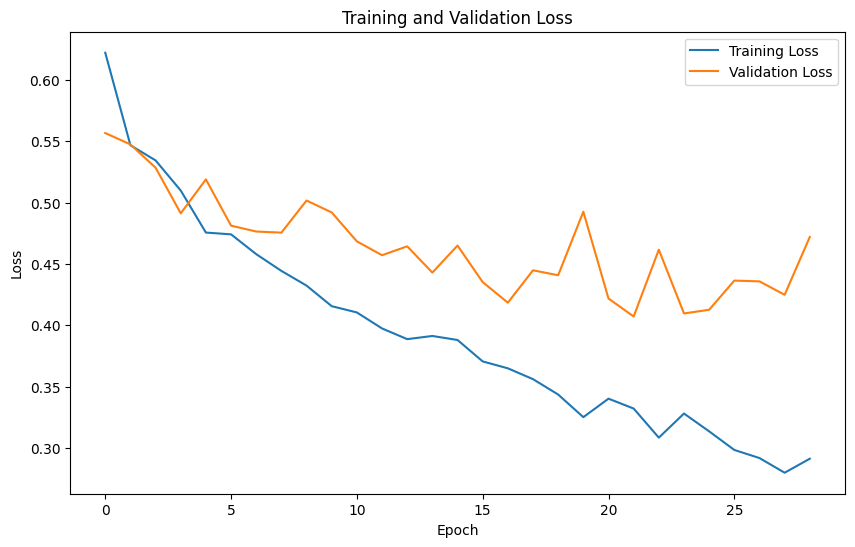

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

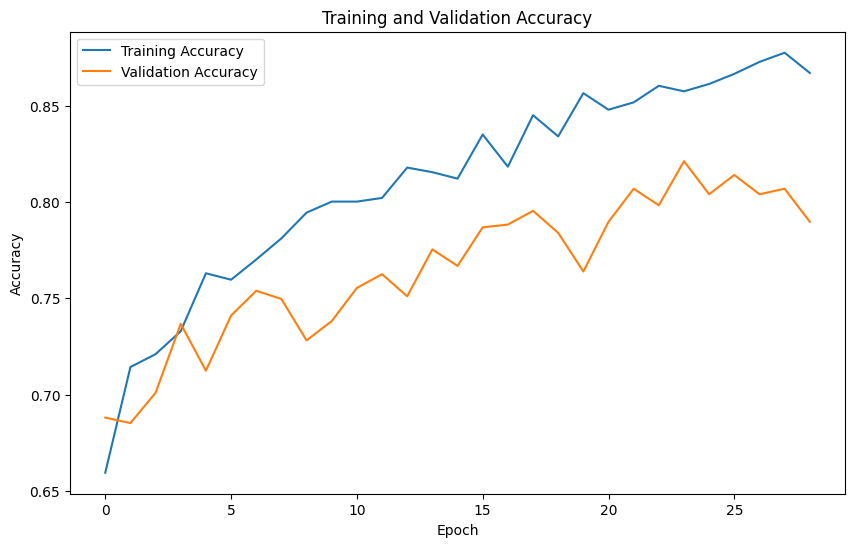

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()